# Inverse Probability Weighting Model
Inverse probability weighting is a basic model to obtain average effect estimation.

It calculates the probability of each sample to belong to its group,   
and use its inverse as the weight of that sample:
$$
w_i = \frac{1}{\Pr[A=a_i | X_i]}
$$

In [1]:
%matplotlib inline
from causallib.datasets import load_nhefs
from causallib.estimation import IPW
from causallib.evaluation import evaluate
from sklearn.linear_model import LogisticRegression

#### Data:
The effect of quitting to smoke on weight loss.  
Data example is taken from [Hernan and Robins Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

In [2]:
data = load_nhefs()
data.X.join(data.a).join(data.y).head()

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2,qsmk,wt82_71
0,42,1,0,30,29,79.04,0,0,0,0,0,0,0,1,1764,6247.3216,900,841,0,-10.093960
1,36,0,0,20,24,58.63,0,0,1,0,0,0,0,0,1296,3437.4769,400,576,0,2.604970
2,56,1,1,20,26,56.81,0,0,1,0,0,0,0,1,3136,3227.3761,400,676,0,9.414486
3,68,1,0,3,53,59.42,1,0,0,0,0,0,0,1,4624,3530.7364,9,2809,0,4.990117
4,40,0,0,20,19,87.09,1,0,1,0,0,0,1,0,1600,7584.6681,400,361,0,4.989251


#### Model:
The causal model has a machine learning model at its core, provided as `learner` parameter.  
This ML model will be used to predict probability of quit smoking given the covariates.  
These probabilities will be used to obtain $w_i$.  
Then, we'll estimate average balanced outcome using Horvitz–Thompson estimator:
$$
\hat{E}[Y^a] = \frac{1}{\sum_{i:A_i=a}w_i} \cdot \sum_{i:A_i=a}w_i y_i
$$

Lastly, we'll use these average counterfactual outcome estimation to predict the effect:
$$
\hat{E}[Y^1] - \hat{E}[Y^0]
$$

In [3]:
# Train:
learner = LogisticRegression(solver="liblinear")
ipw = IPW(learner)
ipw.fit(data.X, data.a)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(solver='liblinear'))

In [4]:
# We can now preict the weight of each individual:
ipw.compute_weights(data.X, data.a).head()

0    1.151658
1    1.202552
2    1.203629
3    1.927535
4    1.336785
dtype: float64

In [5]:
# Estimate average outcome
outcomes = ipw.estimate_population_outcome(data.X, data.a, data.y)
outcomes

0    1.749876
1    5.240249
dtype: float64

In [6]:
# Estimate the effect:
effect = ipw.estimate_effect(outcomes[1], outcomes[0])
effect

diff    3.490373
dtype: float64

We can see that on average, indiviudals who quit smoking gained 3.5 Lbs  
on the course of 11 years

## Non-default parameters
We just saw a simple example hiding many model's parameters.  
We now dig a bit deeper to every stage.

#### Model definition

_Machine learning model:_  
Any scikit-learn model can be specified (even pipelines)

In [7]:
learner = LogisticRegression(penalty="l1", C=0.01, max_iter=500, solver='liblinear')

_IPW model_ has two additional parameters:  
* `clip_min`, `clip_max`: caliper values to trim very small or very large probabilities
* `stabilized`: Whether to scale weights with treatment prevalence

In [8]:
clip_min = 0.2
clip_max = 0.8
ipw = IPW(learner, clip_min=clip_min, clip_max=clip_max, use_stabilized=False)

In [9]:
ipw.fit(data.X, data.a);

#### Weight prediction options

Now we can predict the probability of quit smoking (`treatment_values=1`)  
and validate our truncation worked:

In [10]:
probs = ipw.compute_propensity(data.X, data.a, treatment_values=1)
probs.between(clip_min, clip_max).all()

True

During the "predict" phase (i.e. computing weights or probabilities),  
We can alter the parameters we placed during initiation:  

In [11]:
probs = ipw.compute_propensity(data.X, data.a, treatment_values=1, clip_min=0.0, clip_max=1.0)
probs.between(clip_min, clip_max).all()

False

We can even predict stabilized weights.  
However, we will get a warning.  
This is because treatment prevalence is an estimation of
the trainning data.  
During `fit`, when the model had it's initial values, `use_stabilized` was `False` (default).  
So when coming to `compute_weights` now, the model will use the prevalence from the provided data to estimate treatment prevalence.  
This is not a big deal here, since we compute on the same data we trained on, but this does not have to be the general case.  
(This warning would not exists if we redefine the model with `use_stabilized=True` and re-train it)

In [12]:
stabilized_weights = ipw.compute_weights(data.X, data.a, treatment_values=1, 
                                         clip_min=0.0, clip_max=1.0, use_stabilized=True)
weights = ipw.compute_weights(data.X, data.a, treatment_values=1, 
                              clip_min=0.0, clip_max=1.0)
stabilized_weights.eq(weights).all()

/home/micha/CausalInference/causallib/estimation/ipw.py:137: RuntimeWarning: Stabilized is asked, however, the model was not trained using stabilization, and therefore, stabilized weights are taken from the provided treatment assignment.
  warnings.warn("Stabilized is asked, however, the model was not trained using stabilization, and "


False

Since IPW utilizes probabilites, for each sample we can get a probability (or weight) for each treatment value

In [13]:
# ipw.compute_weight_matrix(data.X, data.a).head()
ipw.compute_propensity_matrix(data.X, data.a).head()

,0,1
0,0.800000,0.200000
1,0.800000,0.200000
2,0.715874,0.284126
3,0.521508,0.478492
4,0.765537,0.234463


#### Effect estimation options
We can choose whether we wish for addtive (`diff`) or multiplicative (`ratio`) effect  
(If outcome `y` was probabilites, we could also ask for odds-ratio (`or`))

Providing weights `w` is optional, if not provided the weights would be simply
calulated again using the provided `X`.

In [14]:
outcomes = ipw.estimate_population_outcome(data.X, data.a, data.y, w=weights)
effects = ipw.estimate_effect(outcomes[1], outcomes[0], effect_types=["diff", "ratio"])
effects

diff     2.753522
ratio    2.141473
dtype: float64

## Evaluation
We can also evaluate the performance of the IPW model

#### Simple evaluation
Evaluates a fitted model on the provided dataset

In [15]:
results = evaluate(ipw, data.X, data.a, data.y)

`results` contains `models`, `plots` and `scores`,
but since we did not ask for plots, and did not refit the model,
our main interest is the scores.
We have both the prediction performance scores and 
a table1 with standardized mean differences with and without balancing

In [16]:
results.evaluated_metrics.prediction_scores

,accuracy,precision,recall,f1,roc_auc,avg_precision,hinge,matthews,0_1,brier,confusion_matrix,roc_curve,pr_curve
0,0.743934,0.541667,0.032258,0.06089,0.613582,0.364388,1.116458,0.081138,0.256066,0.184571,"[[1152, 11], [390, 13]]","([0.0, 0.0008598452278589854, 0.00085984522785...","([0.25734355044699875, 0.2879799666110184, 0.2..."


In [17]:
results.evaluated_metrics.covariate_balance.head()

abs_smd,weighted,unweighted
covariate,,
age,0.048282,0.199560
race,0.167239,0.125194
sex,0.145728,0.113323
smokeintensity,0.018940,0.153345
smokeyrs,0.021279,0.112470


#### Thorough evaluation
Can check general model specification as it evaluates using cross-validation 
and refitting the model on each fold

{'train': {'covariate_balance_slope': <AxesSubplot:ylabel='Absolute Standard Mean Difference'>,
  'pr_curve': <AxesSubplot:title={'center':'PR Curve'}, xlabel='Recall', ylabel='Precision'>,
  'weight_distribution': <AxesSubplot:title={'center':'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>,
  'calibration': <AxesSubplot:title={'center':'Calibration'}, xlabel='Predicted probability', ylabel='Observed probability'>,
  'roc_curve': <AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  'covariate_balance_love': <AxesSubplot:xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>},
 'valid': {'covariate_balance_slope': <AxesSubplot:ylabel='Absolute Standard Mean Difference'>,
  'pr_curve': <AxesSubplot:title={'center':'PR Curve'}, xlabel='Recall', ylabel='Precision'>,
  'weight_distribution': <AxesSubplot:title={'center':'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>,


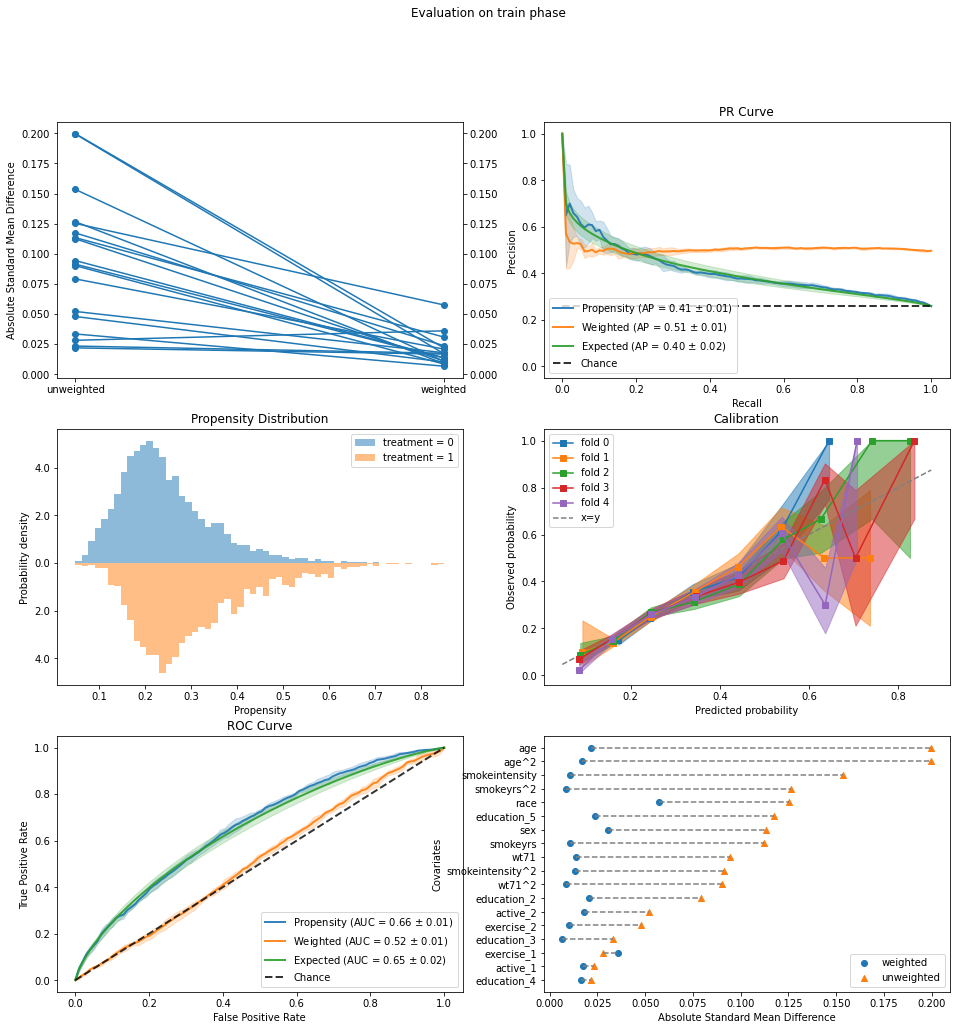

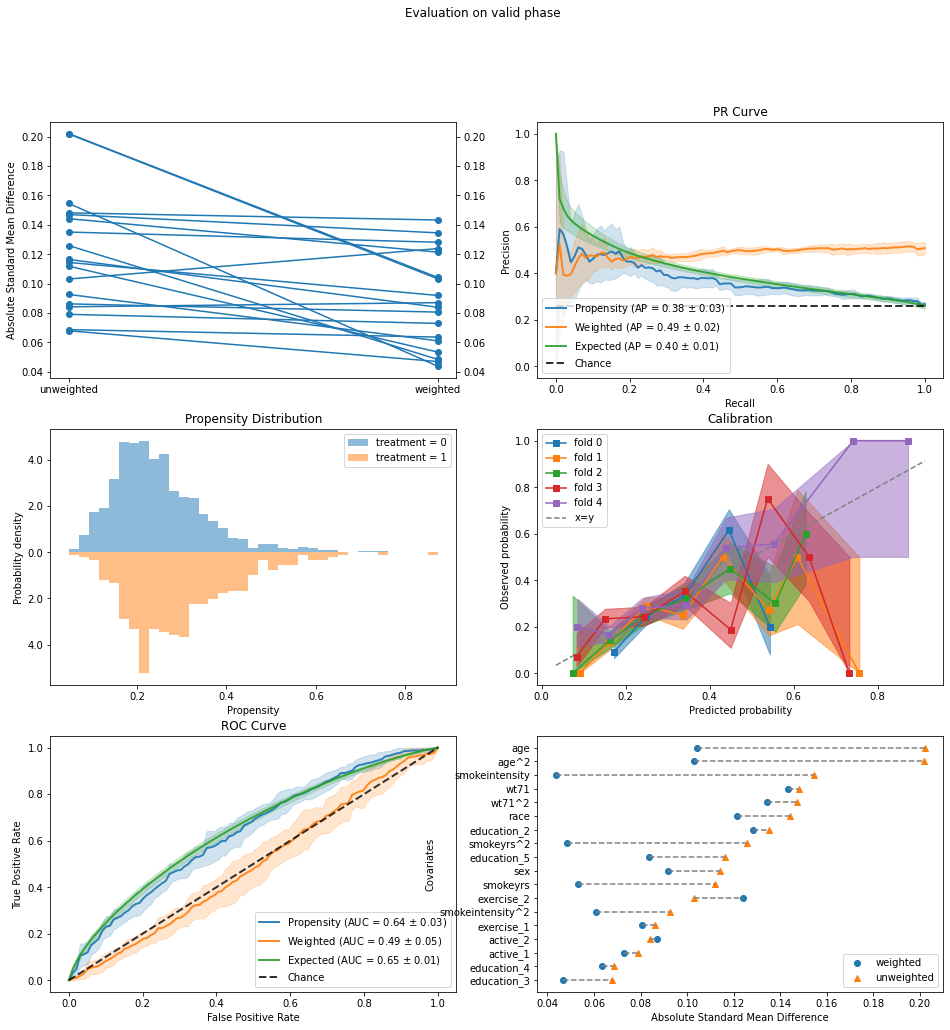

In [18]:
from sklearn import metrics
metrics = {"roc_auc": metrics.roc_auc_score,
           "avg_precision": metrics.average_precision_score,}
ipw = IPW(LogisticRegression(solver="liblinear"))
results = evaluate(ipw, data.X, data.a, data.y, cv="auto", metrics_to_evaluate=metrics)
results.plot_all()

In [19]:
results.evaluated_metrics.prediction_scores

roc_auc  avg_precision
phase fold                           
train 0    0  0.643779       0.391329
      1    0  0.660109       0.408705
      2    0  0.662429       0.411065
      3    0  0.677559       0.430324
      4    0  0.666998       0.395738
valid 0    0  0.666561       0.397005
      1    0  0.643938       0.345606
      2    0  0.663144       0.401750
      3    0  0.591369       0.329489
      4    0  0.621967       0.414739

In [20]:
print(len(results.models))
results.models[2]

5


IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(solver='liblinear'))